# Continuous Control

Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

In [2]:
import random
import torch
import time
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent, ReplayBuffer

from unityagents import UnityEnvironment
import numpy as np


# Load Reacher env with 20 agents
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain information
# Environments contain brains which are responsible for deciding the actions of their associated agents. 
# Here we check for the first brain available, and set it as the default brain we will be controlling from Python.
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine State and Action Spaces

Execute the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. DDPG Agents Initialization

Execute the code cell below to instantiate the DDPG Agents

In [5]:
random_seed = 7
train_mode = True

agent = Agent(state_size=state_size, action_size=action_size, random_seed=random_seed)

### 4.Train the Agents using DDPG

Function Definaton to train the Agents using DDPG

In [6]:
def ddpg(n_episodes=2000, max_t=1000, print_every=10, learn_every=20, num_learn=10, goal_score=30):
    total_scores_deque = deque(maxlen=100)
    total_scores = []
    
    for i_episode in range(1, n_episodes+1):
        # Reset Env and Agent
        env_info = env.reset(train_mode=train_mode)[brain_name]       # reset the environment    
        states = env_info.vector_observations                   # get the current state (for each agent)
        scores = np.zeros(num_agents)                            # initialize the score (for each agent)
        agent.reset()
        
        start_time = time.time()
        
        for t in range(max_t):
            actions = agent.act(states)
            
            env_info = env.step(actions)[brain_name]            # send all actions to the environment
            next_states = env_info.vector_observations          # get next state (for each agent)
            rewards = env_info.rewards                          # get reward (for each agent)
            
            dones = env_info.local_done                         # see if episode finished
            
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done) # send actions to the agent
            
            scores += env_info.rewards                           # update the score (for each agent)
            states = next_states                                # roll over states to next time step
            
            if t%learn_every == 0:
                for _ in range(num_learn):
                    agent.start_learn()
            
            if np.any(dones):                                   # exit loop if episode finished
                break
    
        mean_score = np.mean(scores)
        min_score = np.min(scores)
        max_score = np.max(scores)
        total_scores_deque.append(mean_score)
        total_scores.append(mean_score)
        total_average_score = np.mean(total_scores_deque)
        duration = time.time() - start_time
        
        print('\rEpisode#=> {}\tTotal Average Score=> {:.2f}\tMean=> {:.2f}\tMin=> {:.2f}\tMax=> {:.2f}\t Time Duration=> {:.2f}'
              .format(i_episode, total_average_score, mean_score, min_score, max_score, duration))

        if i_episode % print_every == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode#=> {}\tTotal Average Score=> {:.2f}'.format(i_episode, total_average_score))  
            
        if total_average_score >= goal_score and i_episode >= 100:
            print('!!!!!Problem Been Solved after {} # Episodes!!!! Total Average score=> {:.2f}'.format(i_episode, total_average_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    
    return total_scores

#### Execute the code cell below to train the Agents using DDPG

In [7]:
scores = ddpg()

/home/workspace/ddpg_agent.py:104: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode#=> 1	Total Average Score=> 0.48	Mean=> 0.48	Min=> 0.00	Max=> 1.13	 Time Duration=> 22.14
Episode#=> 2	Total Average Score=> 0.62	Mean=> 0.76	Min=> 0.19	Max=> 1.57	 Time Duration=> 23.59
Episode#=> 3	Total Average Score=> 0.66	Mean=> 0.74	Min=> 0.09	Max=> 1.55	 Time Duration=> 24.06
Episode#=> 4	Total Average Score=> 0.70	Mean=> 0.82	Min=> 0.05	Max=> 1.77	 Time Duration=> 24.22
Episode#=> 5	Total Average Score=> 0.73	Mean=> 0.82	Min=> 0.16	Max=> 1.75	 Time Duration=> 24.56
Episode#=> 6	Total Average Score=> 0.74	Mean=> 0.84	Min=> 0.00	Max=> 1.59	 Time Duration=> 24.84
Episode#=> 7	Total Average Score=> 0.81	Mean=> 1.21	Min=> 0.06	Max=> 3.79	 Time Duration=> 25.27
Episode#=> 8	Total Average Score=> 0.87	Mean=> 1.25	Min=> 0.08	Max=> 3.07	 Time Duration=> 25.45
Episode#=> 9	Total Average Score=> 0.92	Mean=> 1.33	Min=> 0.34	Max=> 3.47	 Time Duration=> 25.92
Episode#=> 10	Total Average Score=> 0.93	Mean=> 1.01	Min=> 0.10	Max=> 1.68	 Time Duration=> 26.23
Episode#=> 10	Total Average S

### 5. Plots of scores

Average Score computations and plot the scores with respect to Episodes

In [80]:
N = 100
cumsum, moving_aves = [0], []

for i, x in enumerate(scores, 1):
    cumsum.append(cumsum[i-1] + x)
    if i>=N:
        moving_ave = (cumsum[i] - cumsum[i-N])/N
        #can do stuff with moving_ave here
        moving_aves.append(moving_ave)
l = [None] * (N-1)
l.extend(moving_aves)
boundary = [30] * len(l)

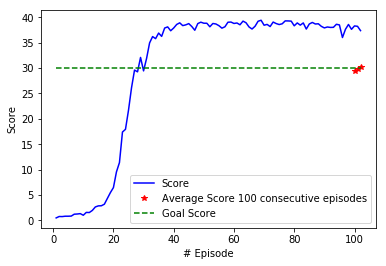

In [81]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(np.arange(1, len(scores)+1), scores, 'b', label='Score')
plt.plot(np.arange(1, len(l)+1), l, 'r*',label='Average Score 100 consecutive episodes')
plt.plot(np.arange(1, len(boundary)+1), boundary, 'g--' ,label='Goal Score')
plt.ylabel('Score')
plt.xlabel('# Episode')
plt.legend(loc='lower right')
plt.show()

### 6. Agent using the saved weights to execute

In [66]:
# Load the saved weights into Pytorch model
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth', map_location='cpu'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth', map_location='cpu'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)

while True:
    actions = agent.act(states)                        # select actions from loaded model agent
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score=> {}'.format(np.mean(scores)))

Total score=> 38.54099913854152


In [80]:
#close the environment
env.close()